In [1]:
!nvidia-smi -L


/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-24 13:24:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-24 13:24:59 (73.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback,plot_loss_curves, compare_historys

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-03-24 13:25:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.207, 142.250.152.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-03-24 13:25:03 (93.3 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df_shuffled=train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
print(f"Total trainiig samples:{len(train_df)}")
print(f"Total test samples:{len(test_df)}")
print(f"Total samples:{len(train_df)+ len(test_df)}")


Total trainiig samples:7613
Total test samples:3263
Total samples:10876


In [10]:
import random
random_index= random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
 _,text ,target=row
print(f"Target:{target}", "(real disaster)" if target>0 else"(not real disaster)")
print(f"Text:\n{text}\n")
print("---\n")


Target:1 (real disaster)
Text:
Cont'd- #Sinjar: referring to a 40-pg document the group put together on the movt of #Yazidi hostages in the days following #IS massacre [2]

---



Splittting data


In [11]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences,train_labels, val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
train_df_shuffled["target"].to_numpy(),
                                                                         test_size=0.1,
                                                                         random_state=42)



In [12]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
text_vectorizer=TextVectorization(max_tokens=None,
                                  standardize="lower_and_strip_punctuation",
                                  split="whitespace",
                                  ngrams=None,
                                  output_mode="int",
                                  output_sequence_length=None)



In [15]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
max_vocab_length=10000
max_length=15
# text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
#                                   output_mode="int",
#                                   output_sequence_length=max_length)
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
text_vectorizer.adapt(train_sentences)

In [18]:
sample_sentence="There's flood in my street!"
text_vectorizer([sample_sentence])


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
random_sentence =random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Damn bloody hot

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[821, 261, 175,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
words_in_vocab=text_vectorizer.get_vocabulary()
top_5_words= words_in_vocab[:5]
bottom_5_words=words_in_vocab[-5:]
print(f"Number of words in vocab:{len(words_in_vocab)}")
print(f"Top 5 most common words:{top_5_words}")
print(f"Bottom 5 least common words:{bottom_5_words}")

Number of words in vocab:10000
Top 5 most common words:['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers
embedding=layers.Embedding(input_dim=max_vocab_length,
                           output_dim=128,
                           embeddings_initializer="uniform",
                           input_length=max_length,
                           name="embedding_1"

                           )
embedding

In [22]:
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
iCASEIT - MFi Certified Lightning Cable - 1m http://t.co/b32Jmvsb1E http://t.co/XKMiJGY59T      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03441312,  0.02665764, -0.03790152, ...,  0.02430805,
          0.01313117,  0.02968972],
        [-0.03441312,  0.02665764, -0.03790152, ...,  0.02430805,
          0.01313117,  0.02968972],
        [ 0.04992029,  0.00257473, -0.04563479, ..., -0.01529151,
         -0.00526532, -0.02803236],
        ...,
        [ 0.01308018, -0.01851754, -0.01286428, ...,  0.00900533,
          0.0360947 , -0.01155189],
        [ 0.01308018, -0.01851754, -0.01286428, ...,  0.00900533,
          0.0360947 , -0.01155189],
        [ 0.01308018, -0.01851754, -0.01286428, ...,  0.00900533,
          0.0360947 , -0.01155189]]], dtype=float32)>

In [23]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03441312,  0.02665764, -0.03790152,  0.02654472, -0.02681539,
        0.02541495,  0.0336371 , -0.03866331,  0.03184007,  0.0400593 ,
        0.03533031,  0.00025214,  0.00378249,  0.04022321,  0.02560789,
       -0.02053412, -0.01497548,  0.04948324, -0.04164206,  0.04292432,
        0.02419596, -0.04615758, -0.03927767, -0.0061209 , -0.02853984,
       -0.01523893,  0.04645189,  0.03468013, -0.02982855,  0.00657257,
       -0.02658942, -0.00355556,  0.00093421, -0.0263225 ,  0.01477296,
        0.03872396, -0.04546747, -0.0199373 , -0.00592419,  0.0259519 ,
       -0.03205065, -0.04412042,  0.00409274,  0.02297015, -0.02621243,
       -0.04931369, -0.01966698,  0.00543725,  0.00925108, -0.02951828,
       -0.00257016,  0.02133625, -0.04499024,  0.03535693,  0.0336164 ,
       -0.01455823, -0.03121004,  0.02216377,  0.02868576, -0.01104159,
       -0.00879688,  0.01139022, -0.00303181, -0.04256063, -0.04514454,
       -0.002216

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0=Pipeline([
    ("tfidf",TfidfVectorizer()),
                   ("clf",MultinomialNB())
                   ])
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score=model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of:{baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of:79.27%


In [26]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)*100
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results={"accuracy":model_accuracy,
                 "precision":model_precision,
                 "recall":model_recall,
                 "f1":model_f1}
  return model_results


In [28]:
baseline_results=calculate_results(y_true=val_labels,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [29]:
from helper_functions import create_tensorboard_callback
SAVE_DIR="model_logs"



In [30]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs, name="model_1_dense")

In [31]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [33]:
model_1_history=model_1.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                            experiment_name="Simple_dense_model")])


Saving TensorBoard log files to: model_logs/Simple_dense_model/20240324-132505
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.6087 - accuracy: 0.6938 - val_loss: 0.5355 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4407 - accuracy: 0.8194 - val_loss: 0.4694 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3459 - accuracy: 0.8615 - val_loss: 0.4593 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2843 - accuracy: 0.8923 - val_loss: 0.4645 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2374 - accuracy: 0.9126 - val_loss: 0.4771 - val_accuracy: 0.7861


In [34]:
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4771 - accuracy: 0.7861


[0.47712692618370056, 0.7860892415046692]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.00460288, -0.00227651,  0.00550256, ...,  0.02680676,
          0.05236988,  0.00628326],
        [-0.03877892,  0.02997606, -0.03282817, ...,  0.02871143,
          0.01634973,  0.03428589],
        [-0.04283921,  0.05964582, -0.01349534, ..., -0.01138797,
         -0.02398235,  0.04157501],
        ...,
        [ 0.00390108, -0.00621967, -0.03871502, ...,  0.01340849,
         -0.02531297, -0.01631086],
        [-0.06277951,  0.00304126,  0.05105437, ...,  0.07491351,
          0.00051722, -0.01200491],
        [-0.01720861,  0.07543526,  0.02174523, ...,  0.04140778,
          0.10152097,  0.03913952]], dtype=float32)>]

In [36]:
embed_weights=model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [37]:
model_1_pred_probs=model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.41579574],
       [0.7441031 ],
       [0.99779373],
       [0.11018355],
       [0.10055937],
       [0.9373027 ],
       [0.91323173],
       [0.9930768 ],
       [0.96807545],
       [0.27079317]], dtype=float32)

In [38]:
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs))

In [39]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [40]:
model_1_results=calculate_results(y_true=val_labels,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [41]:
import numpy as np
np.array(list(model_1_results.values()))>np.array(list(baseline_results.values()))

array([False, False, False, False])

In [42]:
def compare_baseline_to_new_results(baseline_results,new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New{key}:{new_model_results[key]:.2f},Difference:{new_model_results[key]-value:.2f}")
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, Newaccuracy:78.61,Difference:-0.66
Baseline precision: 0.81, Newprecision:0.79,Difference:-0.02
Baseline recall: 0.79, Newrecall:0.79,Difference:-0.01
Baseline f1: 0.79, Newf1:0.78,Difference:-0.00


In [43]:
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [45]:
embed_weights=model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [46]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding=layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=max_length,
                                   name="embedding_2")

inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=model_2_embedding(x)
print(x.shape)
x=layers.LSTM(64)(x)
print(x.shape)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [47]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
model_2.history=model_2.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240324-132528
Epoch 1/5
215/215 [==============================] - 8s 23ms/step - loss: 0.5086 - accuracy: 0.7466 - val_loss: 0.4560 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3168 - accuracy: 0.8720 - val_loss: 0.5133 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2217 - accuracy: 0.9161 - val_loss: 0.5816 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1600 - accuracy: 0.9437 - val_loss: 0.6172 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1124 - accuracy: 0.9590 - val_loss: 0.8580 - val_accuracy: 0.7507


In [50]:
model_2_pred_probs=model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.00720939],
        [0.7773642 ],
        [0.9989277 ],
        [0.07811195],
        [0.00347737],
        [0.99906254],
        [0.8698324 ],
        [0.9995084 ],
        [0.9989472 ],
        [0.59486717]], dtype=float32))

In [51]:
model_2_preds=tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [52]:
model_2_results=calculate_results(y_true=val_labels,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'precision': 0.7504166369758078,
 'recall': 0.7506561679790026,
 'f1': 0.7495084523718772}

In [53]:
compare_baseline_to_new_results(baseline_results,model_2_results)

Baseline accuracy: 79.27, Newaccuracy:75.07,Difference:-4.20
Baseline precision: 0.81, Newprecision:0.75,Difference:-0.06
Baseline recall: 0.79, Newrecall:0.75,Difference:-0.04
Baseline f1: 0.79, Newf1:0.75,Difference:-0.04


In [54]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding=layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=max_length,
                                   name="embedding_3")
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=model_3_embedding(x)
x=layers.GRU(64)(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_GRU")


In [55]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [57]:
model_3_history=model_3.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240324-132550
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.5242 - accuracy: 0.7313 - val_loss: 0.4529 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3189 - accuracy: 0.8697 - val_loss: 0.4922 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2191 - accuracy: 0.9171 - val_loss: 0.5600 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1577 - accuracy: 0.9460 - val_loss: 0.6199 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1197 - accuracy: 0.9594 - val_loss: 0.6116 - val_accuracy: 0.7703


In [58]:
model_3_pred_probs=model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.40181303],
        [0.8825921 ],
        [0.9971279 ],
        [0.16935322],
        [0.01444117],
        [0.9919982 ],
        [0.72824496],
        [0.9975562 ],
        [0.9969256 ],
        [0.36314288]], dtype=float32))

In [59]:
model_3_preds=tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
model_3_results=calculate_results(y_true=val_labels,
                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7699718413593212,
 'recall': 0.7703412073490814,
 'f1': 0.7699305904476158}

In [61]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, Newaccuracy:77.03,Difference:-2.23
Baseline precision: 0.81, Newprecision:0.77,Difference:-0.04
Baseline recall: 0.79, Newrecall:0.77,Difference:-0.02
Baseline f1: 0.79, Newf1:0.77,Difference:-0.02


In [62]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding =layers.Embedding(input_dim=max_vocab_length,
                                    output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=max_length,
                                    name="embedding_4")
inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=model_4_embedding(x)
x=layers.Bidirectional(layers.LSTM(64))(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_4=tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [63]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [65]:
model_4_history=model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240324-132609
Epoch 1/5
215/215 [==============================] - 8s 25ms/step - loss: 0.5102 - accuracy: 0.7438 - val_loss: 0.4585 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3120 - accuracy: 0.8753 - val_loss: 0.5207 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2091 - accuracy: 0.9209 - val_loss: 0.5657 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1419 - accuracy: 0.9536 - val_loss: 0.6646 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1010 - accuracy: 0.9639 - val_loss: 0.6599 - val_accuracy: 0.7664


In [66]:
model_4_pred_probs=model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.02546663],
       [0.85920024],
       [0.99939394],
       [0.14975972],
       [0.00504975],
       [0.9975179 ],
       [0.94769907],
       [0.99948454],
       [0.99967605],
       [0.15631287]], dtype=float32)

In [67]:
model_4_preds=tf.squeeze(tf.round(model_4_pred_probs))

In [68]:
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [69]:
model_4_results=calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7672473559947978,
 'recall': 0.7664041994750657,
 'f1': 0.7646647680054942}

In [70]:
compare_baseline_to_new_results(baseline_results,model_4_results)

Baseline accuracy: 79.27, Newaccuracy:76.64,Difference:-2.62
Baseline precision: 0.81, Newprecision:0.77,Difference:-0.04
Baseline recall: 0.79, Newrecall:0.77,Difference:-0.03
Baseline f1: 0.79, Newf1:0.76,Difference:-0.02


In [71]:
embedding_test=embedding(text_vectorizer(["this is a test sentence"]))
conv_1d =layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output=conv_1d(embedding_test)
max_pool=layers.GlobalMaxPool1D()
max_pool_output=max_pool(conv_1d_output)

In [72]:
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [73]:
embedding_test[:1],conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.03599371,  0.00252582, -0.03987063, ..., -0.03075893,
          -0.02184458,  0.0027919 ],
         [-0.01546111,  0.06655317,  0.05479547, ...,  0.07404874,
           0.07164577, -0.01692761],
         [ 0.02906711, -0.02936251,  0.04575324, ..., -0.0015347 ,
          -0.00388524,  0.02052231],
         ...,
         [-0.00460288, -0.00227651,  0.00550256, ...,  0.02680676,
           0.05236988,  0.00628326],
         [-0.00460288, -0.00227651,  0.00550256, ...,  0.02680676,
           0.05236988,  0.00628326],
         [-0.00460288, -0.00227651,  0.00550256, ...,  0.02680676,
           0.05236988,  0.00628326]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.0417838 , 0.        , 0.0049944 , 0.        , 0.        ,
          0.        , 0.06126612, 0.0143996 , 0.        , 0.        ,
          0.        , 0.02411865, 0.        , 0.        , 0.0373682 ,
          0.01468948, 0.

In [74]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding=layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=max_length,
                                   name="embedding_5")

In [75]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=model_5_embedding(x)
x=layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_5=tf.keras.Model(inputs, outputs, name="model_5_Conv1D")
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [76]:
model_5_history=model_5.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240324-132636
Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.5632 - accuracy: 0.7221 - val_loss: 0.4726 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3413 - accuracy: 0.8589 - val_loss: 0.4757 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2132 - accuracy: 0.9225 - val_loss: 0.5390 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1385 - accuracy: 0.9556 - val_loss: 0.6073 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0969 - accuracy: 0.9675 - val_loss: 0.6732 - val_accuracy: 0.7756


In [77]:
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.6896275 ],
       [0.7388329 ],
       [0.99980694],
       [0.05281898],
       [0.0052293 ],
       [0.993412  ],
       [0.9390577 ],
       [0.99768335],
       [0.99877137],
       [0.12156642]], dtype=float32)

In [78]:
model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [79]:
model_5_results=calculate_results(y_true=val_labels,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 77.55905511811024,
 'precision': 0.7783607884132258,
 'recall': 0.7755905511811023,
 'f1': 0.7730920642120304}

In [80]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, Newaccuracy:77.56,Difference:-1.71
Baseline precision: 0.81, Newprecision:0.78,Difference:-0.03
Baseline recall: 0.79, Newrecall:0.78,Difference:-0.02
Baseline f1: 0.79, Newf1:0.77,Difference:-0.01


In [81]:
import tensorflow_hub as hub
embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples=embed([sample_sentence,
                     "When you call the universal sentence encoder on a sentence,it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.00619159  0.02227651  0.01911679 -0.00839628  0.04681358  0.08478278
  0.03271171  0.05652038 -0.01525857  0.00501371  0.00362281 -0.01900789
  0.02109466  0.09013388  0.06085487 -0.04193015  0.02619381 -0.04802684
  0.00394864 -0.07136868 -0.03342709  0.02137453 -0.00073502  0.01130269
 -0.02827469 -0.05847079  0.03764643 -0.03009782 -0.03493349 -0.01269227
 -0.04895974  0.04952316 -0.05095095  0.02953346  0.0298897  -0.07879895
  0.02671993  0.06460868 -0.026141   -0.09151066  0.02168434  0.01053546
 -0.02609986  0.05582052 -0.10182369 -0.05633939 -0.0085264  -0.03361475
 -0.0464731   0.02264564], shape=(50,), dtype=float32)


In [82]:
embed_samples[0].shape

TensorShape([512])

In [83]:
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      input_shape=[],
                                      dtype=tf.string,
                                      trainable=False,
                                      name="USE")

In [84]:
model_6=tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation="sigmoid")

],
                            name="model_6_USE")
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [85]:
model_6_history=model_6.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentences_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentences_encoder/20240324-132713
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.5027 - accuracy: 0.7846 - val_loss: 0.4495 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4154 - accuracy: 0.8136 - val_loss: 0.4377 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4008 - accuracy: 0.8208 - val_loss: 0.4333 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3936 - accuracy: 0.8262 - val_loss: 0.4285 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3870 - accuracy: 0.8295 - val_loss: 0.4300 - val_accuracy: 0.8163


In [86]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.15049852],
       [0.7248409 ],
       [0.98658305],
       [0.19406967],
       [0.73022175],
       [0.6836538 ],
       [0.9792091 ],
       [0.9734926 ],
       [0.91530395],
       [0.07826742]], dtype=float32)

In [87]:
model_6_preds=tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
model_6_results=calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [89]:
compare_baseline_to_new_results(baseline_results,model_6_results)

Baseline accuracy: 79.27, Newaccuracy:81.63,Difference:2.36
Baseline precision: 0.81, Newprecision:0.82,Difference:0.01
Baseline recall: 0.79, Newrecall:0.82,Difference:0.02
Baseline f1: 0.79, Newf1:0.81,Difference:0.03


In [90]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent,train_labels_10_percent=train_test_split(np.array(train_sentences),
                                                                                                                         train_labels,
                                                                                                                         test_size=0.1,
                                                                                                                         random_state=42)

In [91]:
print(f"Total training examples:{len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")


Total training examples:6851
Length of 10% training examples: 686


In [92]:
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [93]:
model_7=tf.keras.models.clone_model(model_6)
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7.summary()


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [94]:
model_7_history=model_7.fit(x=train_sentences_10_percent,
                            y=train_labels_10_percent,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240324-132727
Epoch 1/5
22/22 [==============================] - 2s 29ms/step - loss: 0.6714 - accuracy: 0.7114 - val_loss: 0.6518 - val_accuracy: 0.7113
Epoch 2/5
22/22 [==============================] - 0s 13ms/step - loss: 0.6043 - accuracy: 0.8076 - val_loss: 0.5973 - val_accuracy: 0.7349
Epoch 3/5
22/22 [==============================] - 0s 13ms/step - loss: 0.5294 - accuracy: 0.8192 - val_loss: 0.5447 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 0s 13ms/step - loss: 0.4645 - accuracy: 0.8324 - val_loss: 0.5105 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 0s 13ms/step - loss: 0.4194 - accuracy: 0.8382 - val_loss: 0.4916 - val_accuracy: 0.7808


In [95]:
model_7_pred_probs=model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 6ms/step


array([[0.28188094],
       [0.7778805 ],
       [0.8863997 ],
       [0.32498962],
       [0.5793272 ],
       [0.8264121 ],
       [0.79199034],
       [0.8212    ],
       [0.81690425],
       [0.12513736]], dtype=float32)

In [96]:
model_7_preds=tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
model_7_results=calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7852692803643447,
 'recall': 0.7808398950131233,
 'f1': 0.77783229852174}

In [98]:
compare_baseline_to_new_results(baseline_results,model_7_results)

Baseline accuracy: 79.27, Newaccuracy:78.08,Difference:-1.18
Baseline precision: 0.81, Newprecision:0.79,Difference:-0.03
Baseline recall: 0.79, Newrecall:0.78,Difference:-0.01
Baseline f1: 0.79, Newf1:0.78,Difference:-0.01


In [99]:
all_model_results=pd.DataFrame({"baseline": baseline_results,
                                "simple_dense":model_1_results,
                                "lstm":model_2_results,
                                "gru":model_3_results,
                                "bidirectional":model_4_results,
                                "conv1d":model_5_results,
                                "tf_hub_sentence_encoder":model_6_results,
                                "tf_hub_10_percent_data":model_7_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.065617,0.750417,0.750656,0.749508
gru,77.034121,0.769972,0.770341,0.769931
bidirectional,76.640420,0.767247,0.766404,0.764665
conv1d,77.559055,0.778361,0.775591,0.773092
tf_hub_sentence_encoder,81.627297,0.818755,0.816273,0.814709
tf_hub_10_percent_data,78.083990,0.785269,0.780840,0.777832


In [100]:
all_model_results["accuracy"]=all_model_results["accuracy"]/100

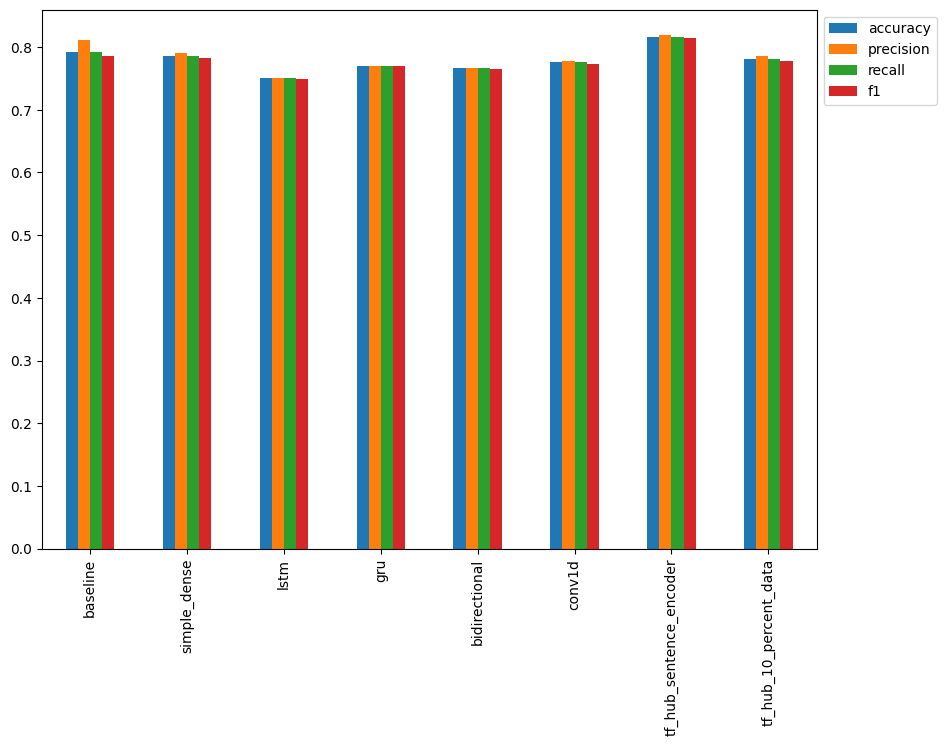

In [101]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

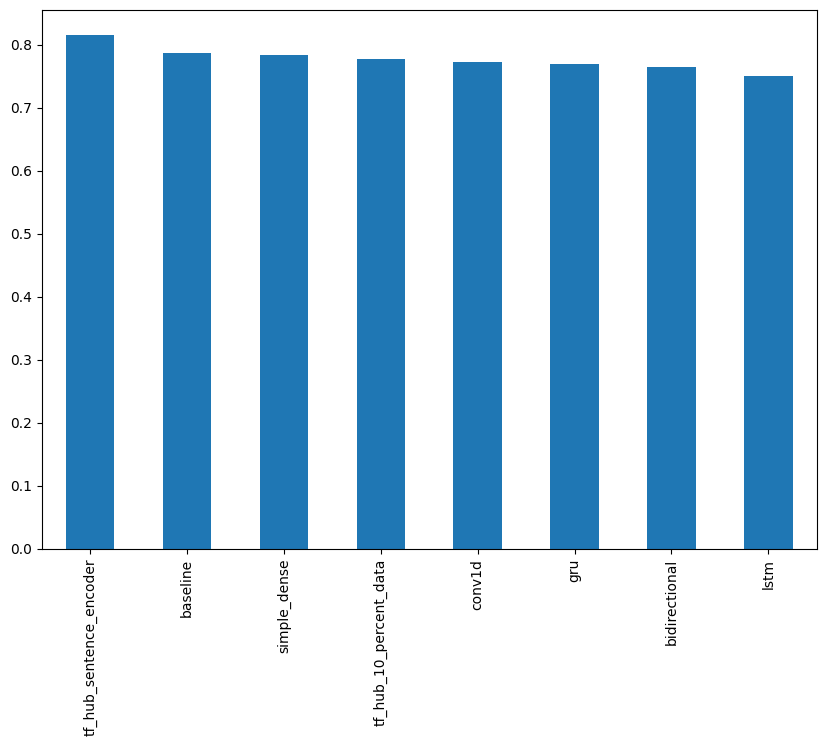

In [102]:
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7));

In [103]:
baseline_pred_probs=np.max(model_0.predict_proba(val_sentences),axis=1)
combined_pred_probs=baseline_pred_probs + tf.squeeze(model_2_pred_probs ,axis=1)
combined_preds=tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [104]:
ensemble_results=calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 75.19685039370079,
 'precision': 0.7649578837521657,
 'recall': 0.7519685039370079,
 'f1': 0.7446474786592545}

In [105]:
all_model_results.loc["ensemble_results"]=ensemble_results
all_model_results.loc["ensemble_results"]["accuracy"]=all_model_results.loc["ensemble_results"]["accuracy"]/100

In [106]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.750656,0.750417,0.750656,0.749508
gru,0.770341,0.769972,0.770341,0.769931
bidirectional,0.766404,0.767247,0.766404,0.764665
conv1d,0.775591,0.778361,0.775591,0.773092
tf_hub_sentence_encoder,0.816273,0.818755,0.816273,0.814709
tf_hub_10_percent_data,0.780840,0.785269,0.780840,0.777832
ensemble_results,0.751969,0.764958,0.751969,0.744647


In [107]:
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [108]:
loaded_model_6=tf.keras.models.load_model("model_6.h5",
                                          custom_objects={"KerasLayer":hub.KerasLayer})

In [109]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4300 - accuracy: 0.8163


[0.4300207793712616, 0.8162729740142822]

In [110]:
model_6.save("model_6_SaveModel_format")

In [111]:
loaded_model_6_SaveModel=tf.keras.models.load_model("model_6_SaveModel_format")

In [112]:
loaded_model_6_SaveModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4300 - accuracy: 0.8163


[0.4300207793712616, 0.8162729740142822]

In [113]:
val_df=pd.DataFrame({"text" :val_sentences,
                     "target":val_labels,
                     "pred":model_6_preds,
                     "pred_prob":tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.150499
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.724841
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986583
3,@camilacabello97 Internally and externally scr...,1,0.0,0.194070
4,Radiation emergency #preparedness starts with ...,1,1.0,0.730222


In [114]:
most_wrong=val_df[val_df["target"]!=val_df["pred"]].sort_values("pred_prob",ascending=False)
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.912142
759,FedEx will no longer transport bioterror patho...,0,1.0,0.850307
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.847186
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.839870
628,@noah_anyname That's where the concentration c...,0,1.0,0.834925
...,...,...,...,...
233,I get to smoke my shit in peace,1,0.0,0.040618
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.036923
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.036779
38,Why are you deluged with low self-image? Take ...,1,0.0,0.036381


In [115]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob=row
  print(f"Target:{target}, Pred:{int(pred)}, Prob:{prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


Target:0, Pred:1, Prob:0.9121417999267578
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target:0, Pred:1, Prob:0.8503068089485168
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target:0, Pred:1, Prob:0.8471859693527222
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target:0, Pred:1, Prob:0.839870035648346
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target:0, Pred:1, Prob:0.834924578666687
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target:0, Pred:1, Prob:0.8243669271469116
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target:0, Pred:1, Prob:0.7960192561149597


In [116]:
for row in most_wrong[-10:].itertuples():
  _,text,target,pred,prob=row
  print(f"Target: {target}, Pred:{int(pred)}, Prob:{prob}")
  print(f"Text:\n{text}\n")
  print("-----\n")


Target: 1, Pred:0, Prob:0.05678795650601387
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

-----

Target: 1, Pred:0, Prob:0.05602231249213219
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred:0, Prob:0.052676208317279816
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, Pred:0, Prob:0.05163534730672836
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, Pred:0, Prob:0.04788842052221298
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, Pred:0, Prob:0.0406181626021862
Text:
I get to smoke my shit in peace

-----

Target: 1, Pred:0, Prob:0.036923110485076904
Text:
@SoonerMagic_ I mean I'm a fan but I don't need

In [117]:
test_sentences=test_df["text"].to_list()
test_samples= random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob=tf.squeeze(model_6.predict([test_sample]))
  pred=tf.round(pred_prob)
  print(f"Pred:{int(pred)}, Prob:{pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("---\n")


1/1 [==============================] - 0s 32ms/step
Pred:0, Prob:0.2400163859128952
Text:
THIS SOUNDS LIKE A SONG YOU WOULD HEAR IN A MOVIE WHERE THEY ARE WALKING AWAY FROM BURNING BUILDINGS AND CARS AND SHIT

---

1/1 [==============================] - 0s 28ms/step
Pred:0, Prob:0.04279196262359619
Text:
I'm bout to get in the shower an drown

---

1/1 [==============================] - 0s 30ms/step
Pred:0, Prob:0.02538822591304779
Text:
Stop saying 'I Wish' and start saying 'I Will'. ÛÒ Unknown

---

1/1 [==============================] - 0s 30ms/step
Pred:1, Prob:0.9382109642028809
Text:
Property losses from northern CA wildfire nearly double http://t.co/fHqx7FiIVJ If you pray please remember CA people/forests/wildlife/water

---

1/1 [==============================] - 0s 28ms/step
Pred:1, Prob:0.8630815148353577
Text:
Fukushima Watch - Fukushima Watch Nuclear Disaster: Welcome. Welcome To Fukushima Watch offering t... http://t.co/M0KJdlwKFB #fukushima

---

1/1 [===================

In [118]:
daniels_tweet="Life like an ensemble: take the best choices from others and make your own"

In [119]:
def predict_on_sentence(model, sentence):
  pred_prob=model.predict([sentence])
  pred_label=tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label>0 else "(not real disaster)", f"prob: {pred_prob[0][0]}")
  print(f"Text:\n {sentence}")

In [120]:
predict_on_sentence(loaded_model_6,
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 265ms/step
Pred: 0.0 (not real disaster) prob: 0.037983085960149765
Text:
 Life like an ensemble: take the best choices from others and make your own


In [121]:
beirut_tweet="Reports that the smoke in Beirut sky contains nitric acid,which is toxic.Please share and refrain from stepping outside unless urgent. #Lebanon"
beirut_tweet_2="#Beirut declared a devastated city, two-week state of emergency officially declared, # Lebanon"

In [122]:
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet)

1/1 [==============================] - 0s 29ms/step
Pred: 1.0 (real disaster) prob: 0.9537292122840881
Text:
 Reports that the smoke in Beirut sky contains nitric acid,which is toxic.Please share and refrain from stepping outside unless urgent. #Lebanon


In [123]:
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 29ms/step
Pred: 1.0 (real disaster) prob: 0.9654334187507629
Text:
 #Beirut declared a devastated city, two-week state of emergency officially declared, # Lebanon


In [124]:
import time
def pred_timer(model, samples):
  start_time=time.perf_counter()
  model.predict(samples)
  end_time=time.perf_counter()
  total_time=end_time-start_time
  time_per_pred=total_time/len(val_sentences)
  return total_time, time_per_pred

In [125]:
model_6_total_pred_time, model_6_time_per_pred=pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 6ms/step


(0.19328942800001414, 0.00025366066666668524)

In [126]:
baseline_total_pred_time, baseline_time_per_pred=pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.01656748899998206, 2.174211154853289e-05)

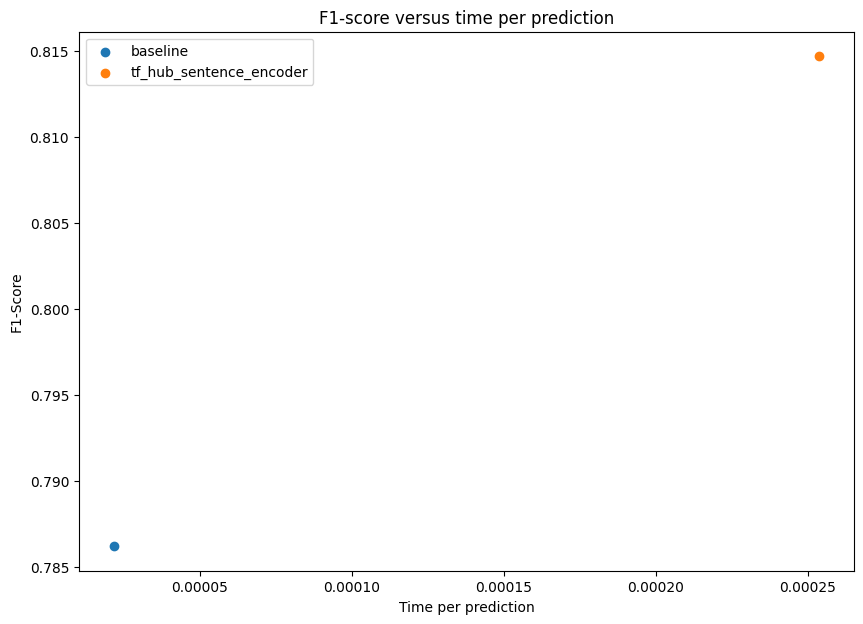

In [127]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");
